3) In dieser Aufgabe soll nun ein kleines Neuronales Netz aus fünf Neuronen zur Erkennung eines Schachbrettmusters auf einem 2x2 Feld programmiert werden. Als Eingabe für das 2x2 Feld nutzen wir einen Vektor mit 4 Einträgen, wobei eine 1 ein schwarzes Feld und eine 0 ein weißes Feld darstellt.
Zu Beginn müssen wir die Klassen HHSimulationOdeint, HHModel und HHParameters aus Aufgabe 2 importieren. Wie bereits gezeigt, ist die odeint Methode die genaueste und schnellste Methode zum Berechnen der GDG und wird fortan verwendet.
Weiter enthält der Code in den folgenden Zeilen eine Methode zum Zeichnen des Schachbretts, die für ein vereinfachtes Verständnis sorgen soll.

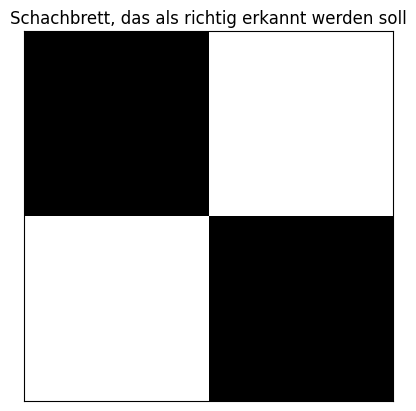

In [2]:
import nbimporter
import numpy as np
import matplotlib.pyplot as plt

from Aufgabe_2 import HHSimulationOdeint, HHModel, HHParameters

# Methode zum Zeichnen des Schachbretts
def zeichne_schachbrett(vektor):
    
    # Wirft Fehler, wenn nicht 1 oder 0, da sonst Graustufen erlaubt wären oder Länge des Vektor ungleich 4
    if len(vektor) != 4 or any(bit not in [0, 1] for bit in vektor):
        raise ValueError("Der Vektor muss genau vier Zahlen enthalten, die 0 oder 1 sein können.")

    # Erstellt ein 2x2-Array 
    schachbrett = np.array(vektor).reshape(2, 2)
    
    # Vektor in String für Title der Grafik
   
    vector_str = ', '.join(map(str, vektor))
    
    # Erstellt das Schachbrett
    plt.imshow(schachbrett, cmap='gray_r', vmin=0, vmax=1)
    plt.xticks([])  # Entferne x-Achsenmarkierungen
    plt.yticks([])  # Entferne y-Achsenmarkierungen
    plt.title(f'Schachbrett, das als richtig erkannt werden soll')
    plt.show()

good_pattern = [1, 0, 0, 1]

# Zeichne das Schachbrett
zeichne_schachbrett(good_pattern) 

In [3]:
params = HHParameters()
hh_model = HHModel(params)

Wir geben zur Implementierung der Trainingsdaten verschiedene Vektoren vor, die die unterschiedlichen möglichen Muster auf dem 2x2 Brett darstellen, in possible_patters vor. Dabei ist zu beachten, dass jedes Brett immer aus zwei weißen und zwei schwarzen Feldern besteht. good_pattern enthält den Vektor, den wir als korrekt erkennen wollen. Im gegebenen Fall ist dies das Brett, welches oben links und unten rechts ein schwarzes Feld aufweist.
Da das Neuronale Netz aus 5 Neuronen, also vier Input-Neuronen (je eins für jedes Feld auf dem Brett) und einem Output-Neuron (Muster vorhanden/Muster nicht vorhanden) bestehen soll, ist es nur möglich eine der beiden Diagonalen als richtiges Muster zu erkennen:

Wollen wir beide Diagolen erkennen, setzt dies voraus, dass das Skalarprodukt des Vektors $$ \mathbf{v_1} = [1, 0, 0, 1] $$ und dem Wichtungssvektor $$ \mathbf{w} = [w_1, w_2, w_3, w_4]$$

$$
\mathbf{v_1} \cdot \mathbf{w} = 1 \cdot w_1 + 0 \cdot w_2 + 0 \cdot w_3 + 1 \cdot w_4 = w_1 + w_4
$$

größer als der Aktivierungswert \(A\) des Output-Neurons ist:

$$
w_1 + w_4 > A \Rightarrow w_1 \text{ oder } w_4 > \frac{A}{2}
$$

Gleichzeitig muss aber auch für die andere Diagonale, die der Vektor $$ \mathbf{v_2} = [0, 1, 1, 0] $$ beschreibt, gelten:
$$
\mathbf{v_2} \cdot \mathbf{w} = 0 \cdot w_1 + 1 \cdot w_2 + 1 \cdot w_3 + 0 \cdot w_4 = w_2 + w_3 $$
woraus resultiert, dass auch 
$$ 
w_2 \text{ oder } w_3 > \frac{A}{2}
$$


Dann folgt daraus aber unweigerlich auch,  dass auch die Summe zwei andere Elemente aus dem Wichtungsvektor (die größer A/2 sind) größer als A ist und dadurch ein falsches Muster als richtig erkannt werden würde.



Die optimalen Wichtungsfaktoren (diese sollen Werte zwischen 0 und 1 annehmen) zur Erkennung des Musters sind 1 für die gewünschten schwarzen Felder, also oben links und unten rechts und 0 auf den anderen beiden Feldern. 

Da ein guter Trainingsdatensatz etwa zur Hälfte aus dem richtigen Muster und zur anderen Hälfte aus falschen Mustern bestehen sollte, lassen wir den Trainingsdatensatz zu 40% aus dem good_pattern und zu 60% aus einem zufällig geshuffleten Vektor aus zwei Einsen und zwei Nullen bestehen. Der Trainingsdatensatz enthält 25 Muster.

In [4]:
possible_patterns = [[1, 1, 0, 0], [1, 0, 1, 0], [1, 0, 0, 1], [0, 1, 1, 0], [0, 1, 0, 1], [0, 0, 1, 1]]
good_pattern = [1, 0, 0, 1]

training_data_length = 25
training_data = np.zeros((training_data_length, 4), dtype=int)

# updated den array `training_data` mit neu generierten Daten
def make_new_training_data():
    for i in range(training_data_length):
        pattern = np.array([1, 1, 0, 0])
        
        # extra 40% chance, das gesuchte Pattern einzufügen, damit wir einen Anteil von ca 50% erreichen
        if np.random.rand() < 0.4:
            pattern = good_pattern
        else: 
            np.random.shuffle(pattern)

        training_data[i] = pattern

make_new_training_data()

Nachdem der Satz für die Trainingsdaten initialisert wurde, kann nun die Klasse für das Neuronale Netz geschrieben werden. 
Die Wichtigunsfaktoren werden in einem Vektor Länge 4 dargestellt (Annahme für optimalen Vektor der Wichtungsfaktoren: [1, 0, 0, 1]) und per Skalarprodukt mit dem Vektor, der das Muster darstellt, verrechnet. 
Wenn man die die Wichtungsfaktoren  als Skalarprodukt mit dem Vektor für das als richtig zu erkennende Muster nimmt, erhalten wir 2 als Ergebniss, während ein Vektor, der nicht dem gesuchten Muster entspricht, eine 1 oder 0 als Ergbniss ausgeben würde.  
Dieses Ergbenis wird mit dem extern anliegenden Strom und dem Faktor 6 multipliziert und als ein sekündiger Inputstromimpuls für das HHModel genommen. So ist sichergestellt, dass nur bei einem richtigen Muster ein Ausschlag in der Spannung des HHModels entsteht. Der maximale Wert der Spannung U wird durch eine Sigmoidfunktion transformiert, um eine Entscheidung zu treffen.

In [5]:
class NN_5_Neurons:

    # weights ist ein Vektor mit Länge 4
    def __init__(self, weights):
        self.weights = np.array(weights)

    @staticmethod
    def getInputCurrent(weightedSum):
        def I_ext(t):
            return  6 * weightedSum if t < 1 else -5
        return I_ext

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def is14DiagonalBlack(self, pattern):
        weightedSum = np.dot(self.weights, pattern)
        I_ext = self.getInputCurrent(weightedSum)

        _, U, _, _, _ = HHSimulationOdeint(hh_model, time=10, dt=0.01, I_ext=I_ext).run()

        return self.sigmoid(max(U) / 10)



3.c) Zum Test sollen alle Wichtungsfaktoren auf 1 gesetzt werden (entspricht dem Vektor [1, 1, 1, 1]) und das Ergebnis mit den von uns als gut angenommenen Wichtungsfaktoren [1, 0, 0, 1] verglichen werden:

In [6]:
# die guten Gewichte um unser Pattern zu erkennenm, entsprechen einfach dem gesuchten Pattern
good_weights = np.copy(good_pattern)

nn_ones = NN_5_Neurons(weights=[1, 1, 1, 1])
results_ones = [nn_ones.is14DiagonalBlack(pattern) for pattern in possible_patterns]

print(f"results for NN with 1 as all weights: {results_ones}")

nn_good = NN_5_Neurons(good_weights)
results_good = [nn_good.is14DiagonalBlack(pattern) for pattern in possible_patterns]

print(f"results for NN with good weights: {results_good}")

print(f"perfect results: {[1 if pattern == good_pattern else 0 for pattern in possible_patterns]}")

results for NN with 1 as all weights: [0.9802052204143038, 0.9802052204143038, 0.9802052204143038, 0.9802052204143038, 0.9802052204143038, 0.9802052204143038]
results for NN with good weights: [0.002499846102356341, 0.002499846102356341, 0.9802052204143038, 0.0015016926560934998, 0.002499846102356341, 0.002499846102356341]
perfect results: [0, 0, 1, 0, 0, 0]


Für ein als richtig erkanntes Muster soll dabei ein Wert nahe 1 ausgebene werden, während ein als falsch erkanntes Muster einem Wert gegen 0 entspricht.
Es ist zu erkennen, dass wenn alle Wichtungsfaktoren auf 1 gesetzt sind, jedes Muster als "richtig" erkannt wird, auch wenn es eigentlich ein falsches Muster ist. Dies entspricht den Erwartungen, da das Ergebnis des Skalarproduktest bei einem Vektor für die Wichtungsfaktoren von [1, 1, 1, 1] immer 2 ergibt.
Schaut man allerdings auf die Ergebnisse für die für gut angenommenen Wichtungsfaktoren, wird jedes Ergebnis mit einer Abweichung von maximal 0,0025 von dem gewünschten Ergebnis als richtig erkannt wird. 

3.d)
Der Algorithmus zum maschinellen Lernen soll geschrieben werden. Dies ist eine einfache Implementation des Konzeptes der Backpropagation.
Dafür werden zuerst die Wichtungsfaktoren zufällig zwischen 0 und 1 gewählt.

Die Wichtungsfaktoren und der Loss werden in zwei Arrays während des Trainings zwischengespeichert.
Es wird ein zufälliges Muster vorgegeben und das Neuronale Netz errechnet ein Ergebnis zwischen 0 und 1. 
Der Loss stellt dabei die Abweichung des Ergebnisses vom zu erwartenden, richtigen Ergebnis (1 oder 0) für das entsprechende Pattern dar. 

Bach jedem Muster werden die Wichtungsfaktoren für die Input Neuronen angepasst, die ein schwarzes Feld als Eingabe bekommen haben.
Bei einem positiven Loss (richtiges Pattern wird als falsch erkannt) werden die entsprechenden Gewichtungsfaktoren also um dem den Loss erhöht. 
Sollte ein negativer Loss (falsches Pattern wird als richtig erkannt) berechnet worden sein, werden die Gewichtungsfaktoren entsprechend verringert.
Daher können niemals die Gewichte 2 und 3 erhöht werden. Es kann allerdings passieren, dass die Gewichte 1 und 4  verringert werden. Wenn beispielsweise der Vektor [1, 1, 0, 0] fälschlicherweise als richtig erkannt wird, werden dementsprechend Wichtungsfaktor eins und zwei mit dem berechneten Loss multipliziert und um den Betrag verringert.
So wird dafür gesorgt, dass die Wichtungsfaktoren bei einer falschen Vorhersage solange angepasst werden bis das NN die Ergebnisse genau vorhersagt. 

Um die Robustheit des Lernalgorithmus zu testen, wird das Training 10 mal mit unterschiedlichen Start-Gewichten durchgeführt und durchläuft je 25 Iterationen.

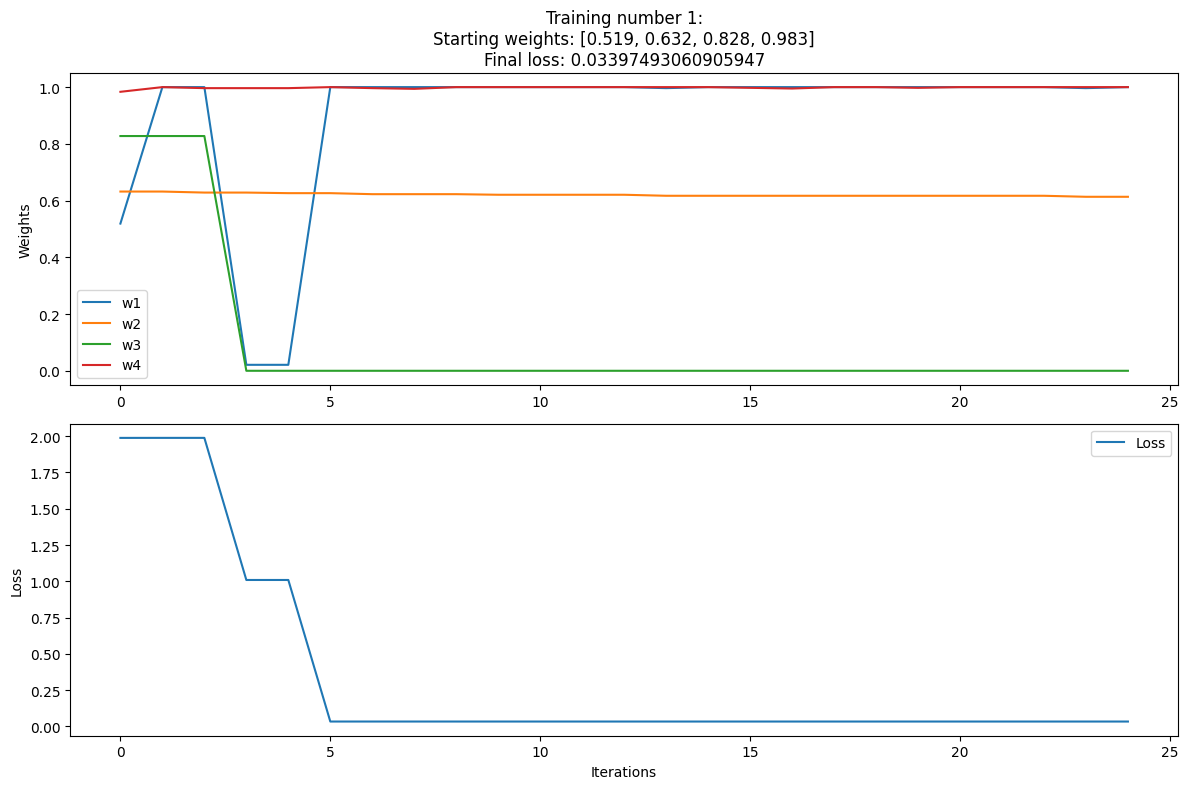

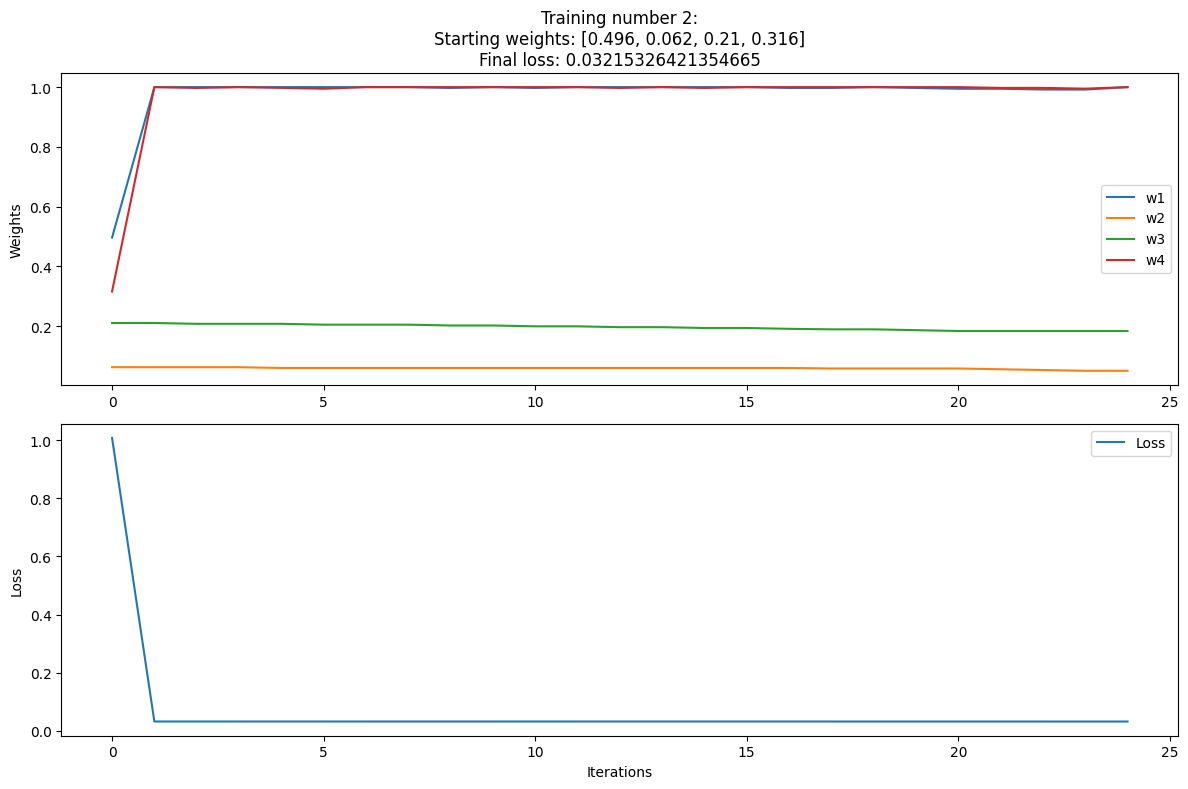

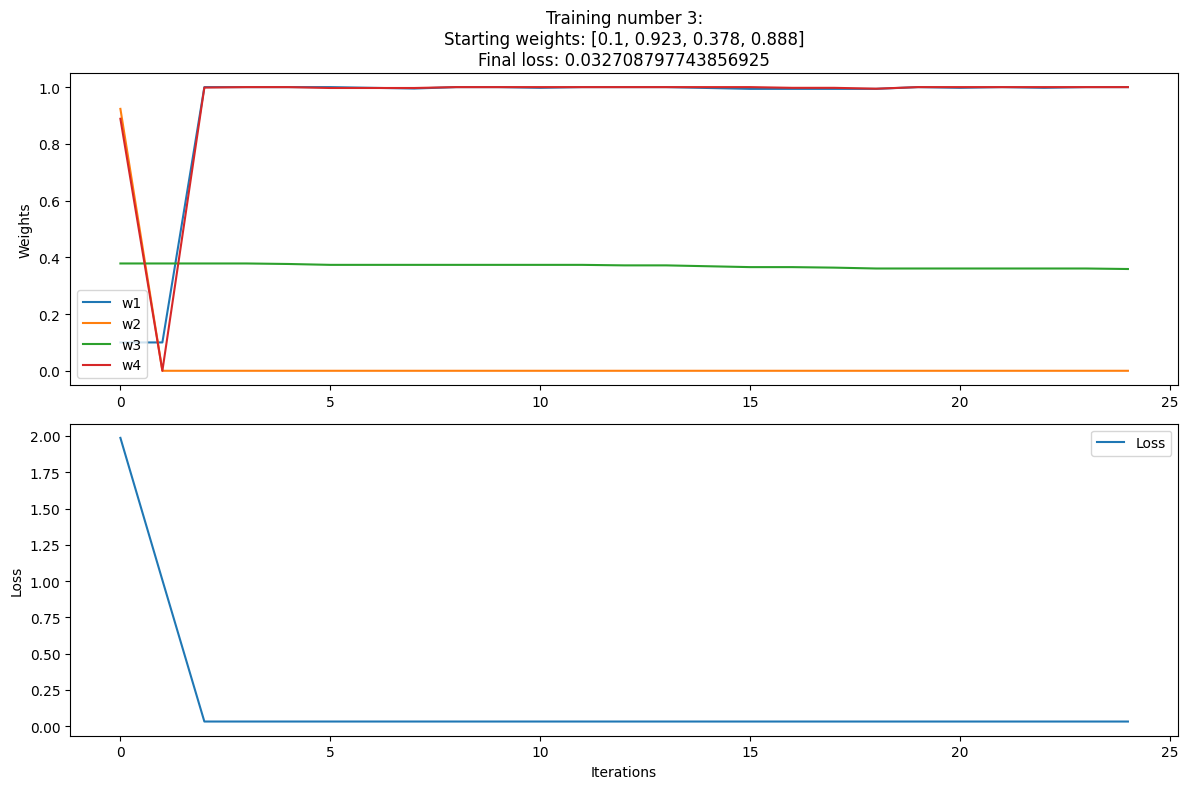

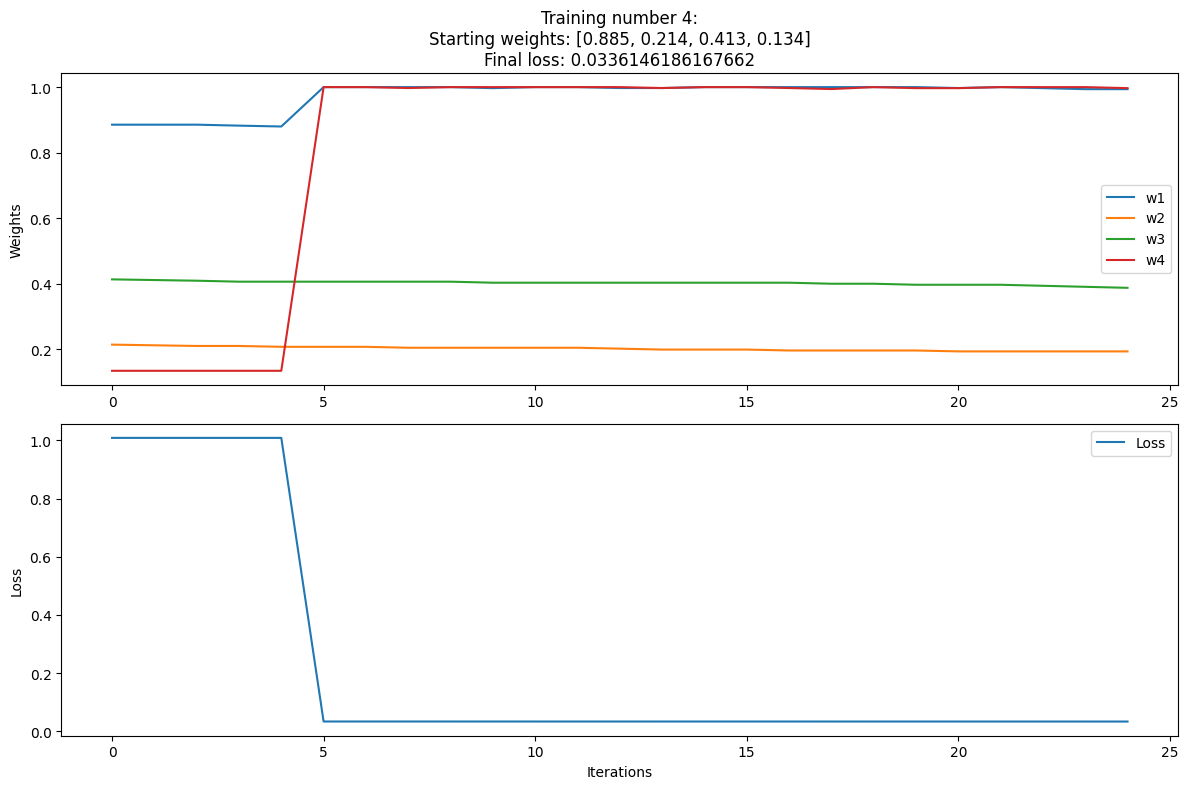

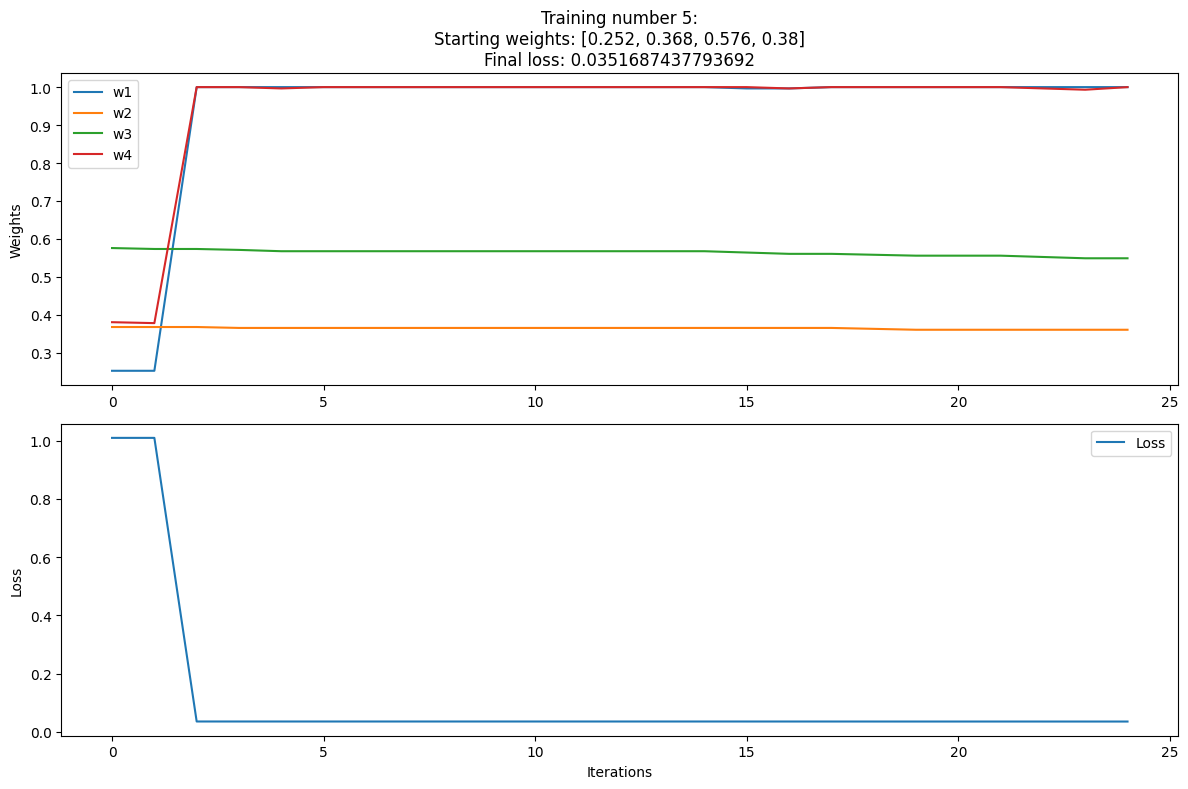

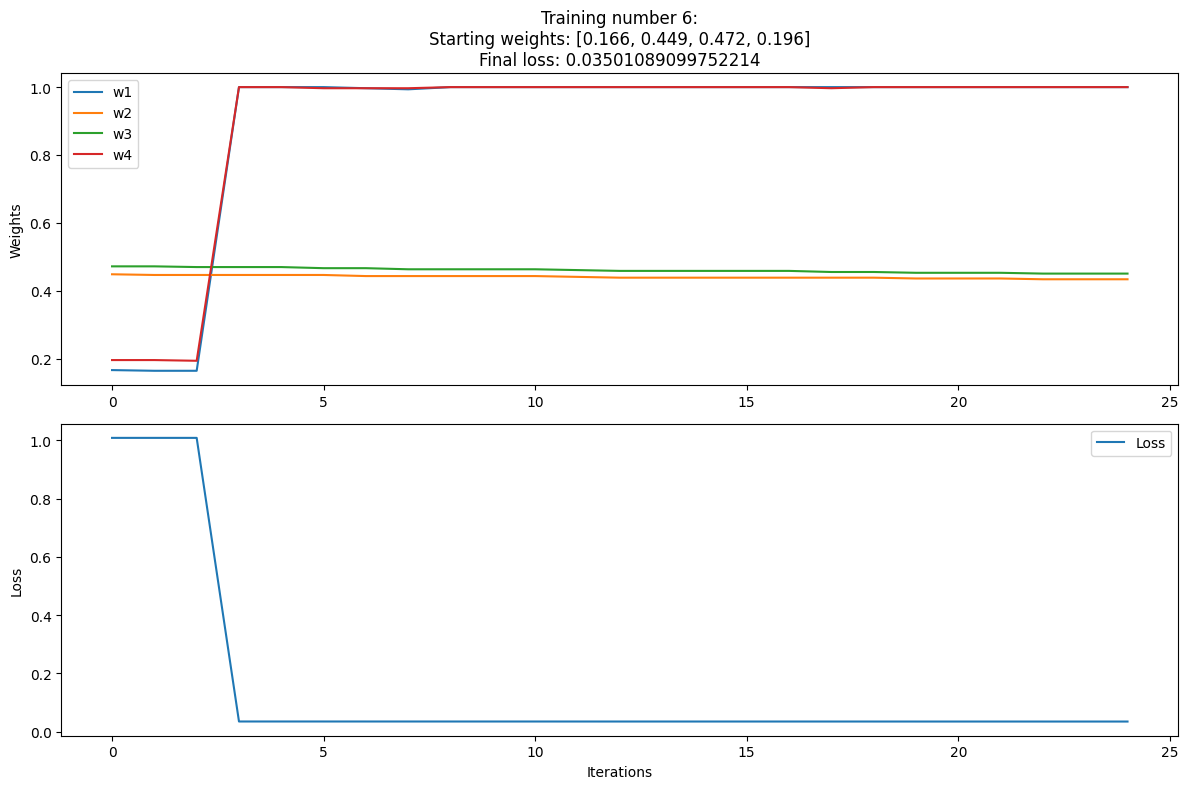

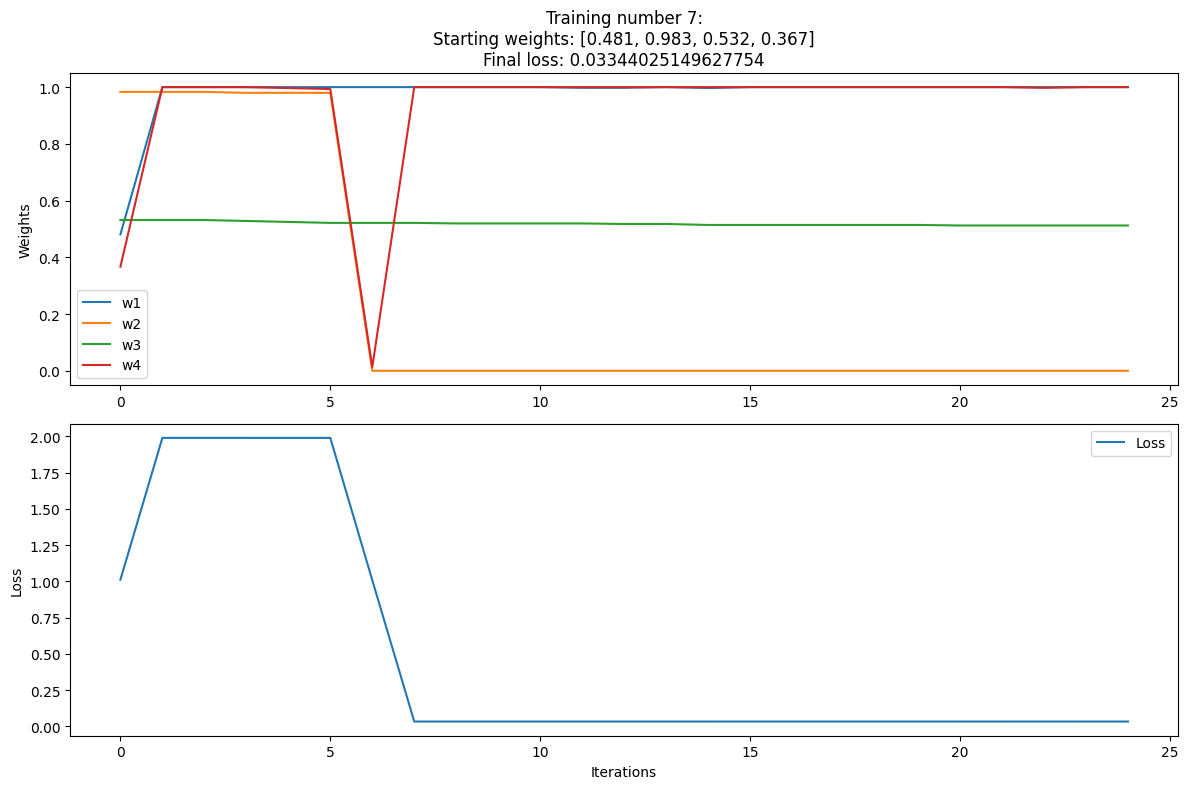

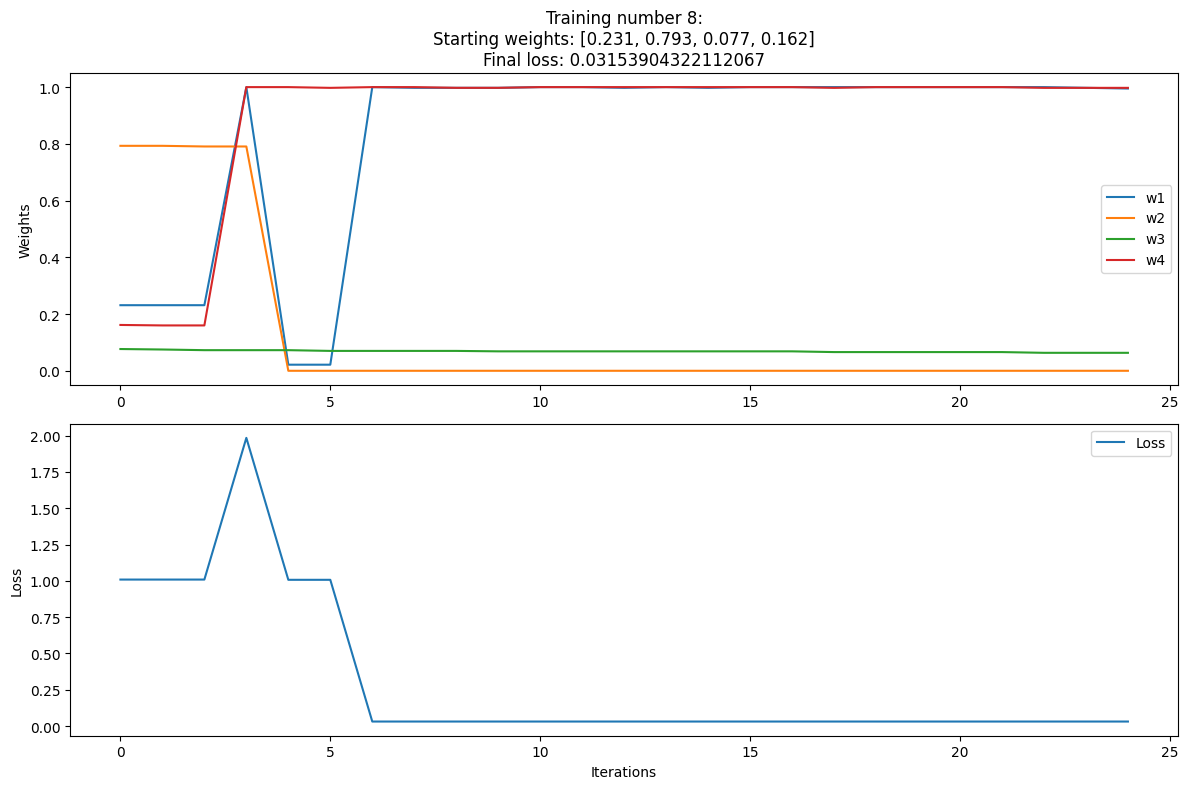

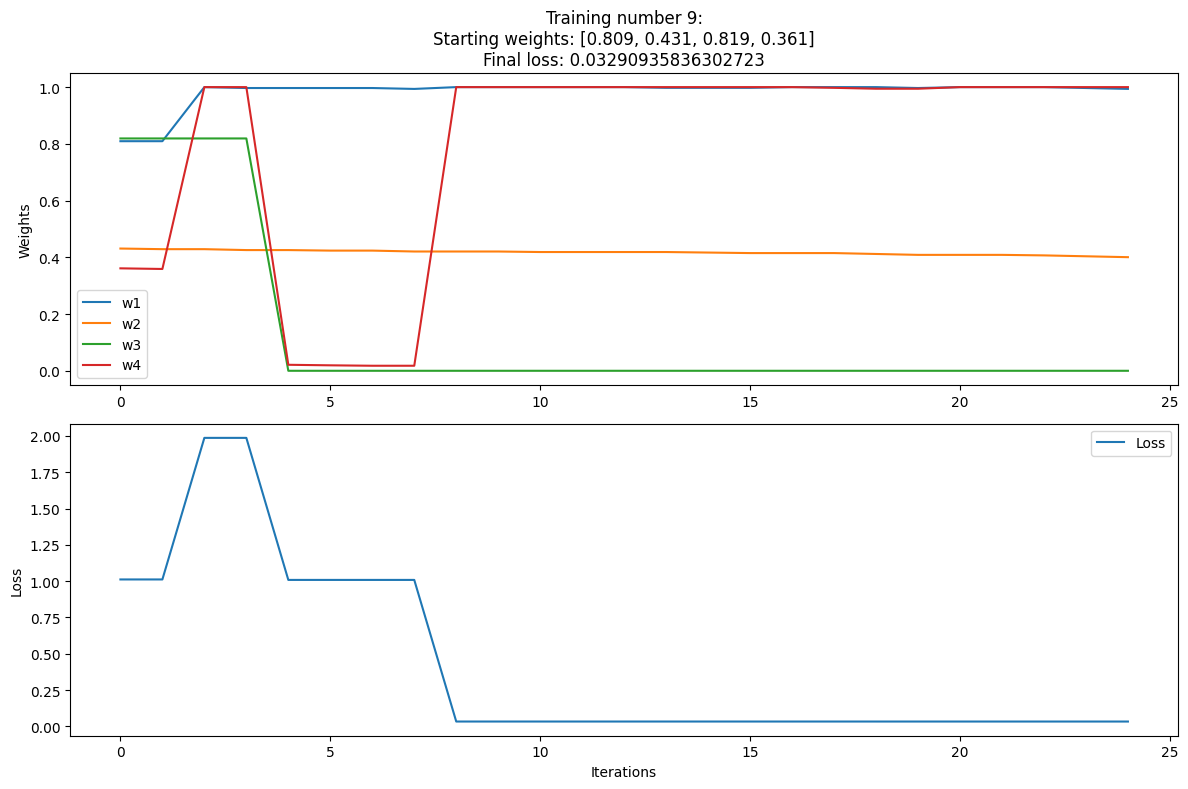

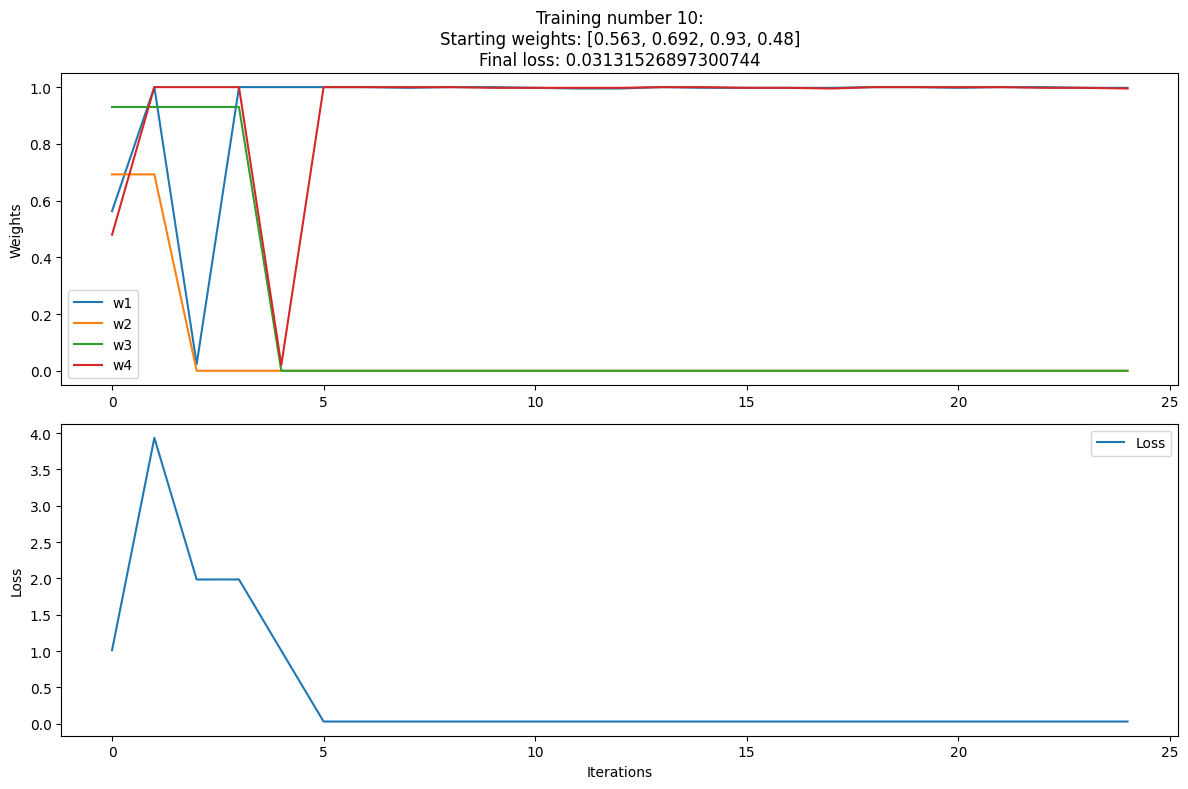

biggest loss after training: 0.0351687437793692


In [7]:
import matplotlib.pyplot as plt

# loss_for_single_pattern kann positiv oder negativ, was einem zu niedrigem bzw zu hohen Ergebnis entspricht
def loss_for_single_pattern(weights, pattern):
    nn = NN_5_Neurons(weights)
    return np.array_equal(pattern, good_pattern) - nn.is14DiagonalBlack(pattern)

# loss_total > 0 
def loss_total(weights):
    return sum(abs(np.array([loss_for_single_pattern(weights, pattern) for pattern in possible_patterns])))


def training():
    weights = np.random.rand(4)

    # wir speichern den Loss und die Weights nach jedem Trainingsstep, also nach jedem Pattern
    losses_during_training = np.array([0.] * training_data_length)
    weights_during_training = np.array([weights] * training_data_length)

    for i, pattern in enumerate(training_data):
        loss = loss_for_single_pattern(weights, pattern)

        losses_during_training[i] = loss_total(weights)
        weights_during_training[i] = weights

        # the weights that contributed to the loss are the ones that got 1 as input
        # those weights get decreased or increased depending on loss < 0 or loss > 0
        # the change in those weights is proportional to the absolute value of the loss 
        weights += loss * pattern
        weights = np.clip(weights, 0, 1)

    return losses_during_training, weights_during_training


biggest_final_loss = 0

for i in range(10):
    losses, weights = training()

    biggest_final_loss = max(biggest_final_loss, losses[-1])

    # um zu zeigen, dass der Algorithmus robust ist, verwenden wir beim nächsten training andere Trainingsdaten
    make_new_training_data()

    # Plot der Entwicklung des losses und der weights
    plt.figure(figsize=(12, 8))

    # Weights
    plt.subplot(2, 1, 1)
    plt.title(f"Training number {i + 1}:\nStarting weights: {list(np.round(weights[0], 3))}\nFinal loss: {losses[-1]}")

    plt.plot(weights[:, 0], label="w1")
    plt.plot(weights[:, 1], label="w2")
    plt.plot(weights[:, 2], label="w3")
    plt.plot(weights[:, 3], label="w4")

    plt.ylabel("Weights")
    plt.legend()

    # Loss
    plt.subplot(2, 1, 2)
    plt.plot(losses, label="Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

print(f"biggest loss after training: {biggest_final_loss}")

Es zeigt sich, dass nach dem Training von dem Neuronalen Netz mit einer maximalen Abweichung von ca 0.035 ein richtiges von einem falschen Pattern unterschieden werden kann.

Man kann an den Plots gut erkennen, dass die Gewichte 2 und 3, wie vorher argumentiert, nie erhöht werden.  

Außerdem ist interessant, dass der Loss durchaus kurzfristig größer werden kann, wenn beispielsweise w2 und w3 von Beginn an hoch gewählt wurden und dann zuerst auf das richtige Pattern trainiert wird und dadurch auch w1 und w4 erhöht werden, sodass alle Werte nah an 1 sind und ein hoher Gesamtfehler entsteht, da alle Muster wie oben bereits diskutiert als richtig erkannt werden.  

Sobald eins der falschen Muster im Training vorkommt, werden entsprechend w2 oder w3 oder beide reduziert und der Loss sinkt wieder.